# Notebook showing how to run PDF summarizer on Spark
In this notebook we'll walk through what's in `run.py`, which shows how one
can setup a spark job to run the PDF summarizer dataflow defined in  `summarization.py`.

Note: if you're on a mac you might need to do the following in your environment as you start jupyter/this kernel:
> OBJC_DISABLE_INITIALIZE_FORK_SAFETY=YES

For your OPENAI_API_KEY you can put it in the enviornment as well, or modify this notebook directly.

In [ ]:
# imports
import os
import pandas as pd
import summarization
from pyspark.sql import SparkSession

from hamilton import driver, log_setup
from hamilton.plugins import h_spark

In [ ]:
# more setup for spark, etc.
openai_api_key = os.environ.get("OPENAI_API_KEY")
log_setup.setup_logging(log_level=log_setup.LOG_LEVELS["INFO"])
# create the SparkSession -- note in real life, you'd adjust the number of executors to control parallelism.
spark = SparkSession.builder.config(
    "spark.executorEnv.OPENAI_API_KEY", openai_api_key
#).config( # you might need to following in case things don't work for you.
#    "spark.sql.warehouse.dir", "~/temp/dwh"
#).master(
#    "local[1]"  # Change this in real life.
).getOrCreate()
spark.sparkContext.setLogLevel("info")

In [3]:
# Set up specifics for this example
openai_gpt_model = "gpt-3.5-turbo-0613"
content_type = "Scientific article"
user_query = "Can you ELI5 the paper?"

In [ ]:
# Create the input dataframe
# replace this with SQL or however you'd get the data you need in.
pandas_df = pd.DataFrame(
    # TODO: update this to point to a PDF or two.
    {"pdf_source": ["a/path/to/a/PDF/CDMS2022-hamilton-paper.pdf"]}
)
df = spark.createDataFrame(pandas_df)
df.show()

In [5]:
# Create the driver
modules = [summarization]
driver_config = dict(file_type="pdf")
# create the Hamilton driver
adapter = h_spark.PySparkUDFGraphAdapter()
dr = driver.Driver(driver_config, *modules, adapter=adapter)  # can pass in multiple modules


[WARNING] 2023-08-19 14:05:57,410 hamilton.telemetry(127): Note: Hamilton collects completely anonymous data about usage. This will help us improve Hamilton over time. See https://github.com/dagworks-inc/hamilton#usage-analytics--data-privacy for details.


In [6]:
# create inputs to the UDFs - this needs to be column_name -> spark dataframe.
execute_inputs = {col: df for col in df.columns}
# add in any other scalar inputs/values/objects needed by the UDFs
execute_inputs.update(
    dict(
        openai_gpt_model=openai_gpt_model,
        content_type=content_type,
        user_query=user_query,
    )
)


In [7]:
# tell Hamilton what columns need to be appended to the dataframe.
cols_to_append = [
    "raw_text",
    "chunked_text",
    "summarized_text",
]

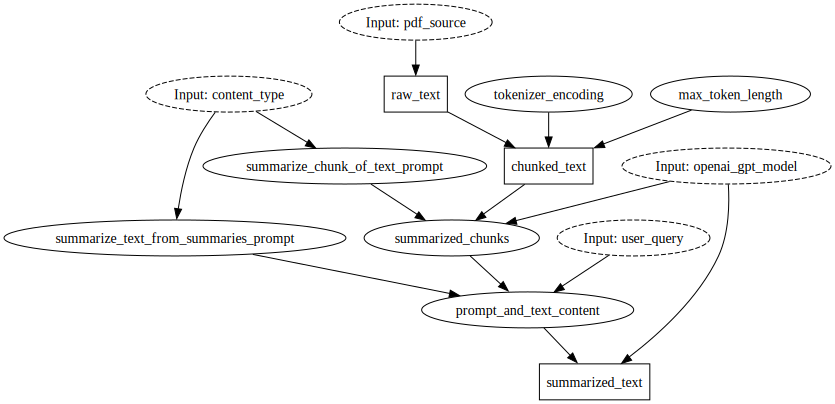

In [8]:
# visualize execution of what is going to be appended
dr.visualize_execution(
    cols_to_append, None, None, inputs=execute_inputs
)

In [ ]:
# tell Hamilton to tell Spark what to do
df = dr.execute(cols_to_append, inputs=execute_inputs)
df.explain()

In [ ]:
df.show()
# you can also save the dataframe as a json file, parquet, etc.
# df.write.json("processed_pdfs")
spark.stop()